<h2><center>Deep Learning for Time Series Forecasting</center></h2>

### The goal of this notebook is to develop and compare different approaches to time-series problems.

#### Content:
* [Time series visualization with ploty](#Basic-EDA).
* [How to transform a time series dataset into a supervised learning problem](#Transform-the-data-into-a-time-series-problem).
* [How to develop a Multilayer Perceptron model for a univariate time series forecasting problem](#MLP-for-Time-Series-Forecasting).
* [How to develop a Convolutional Neural Network model for a univariate time series forecasting problem](#CNN-for-Time-Series-Forecasting).
* [How to develop a Long Short-Term Memory network model for a univariate time series forecasting problem](#LSTM-for-Time-Series-Forecasting).
* [How to develop a Hybrid CNN-LSTM model for a univariate time series forecasting problem](#CNN-LSTM-for-Time-Series-Forecasting).

#### The content here was inspired by this article at **machinelearningmastery.com**, [How to Get Started with Deep Learning for Time Series Forecasting (7-Day Mini-Course)](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)

#### Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Loading data

In [2]:
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])

### Train set

In [3]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [4]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


### Time period of the train dataset

In [5]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


#### Let's find out what's the time gap between the last day from training set from the last day of the test set, this will be out lag (the amount of day that need to be forecast)

In [6]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


### Basic EDA

To explore the time series data first we need to aggregate the sales by day

In [7]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

### Overall daily sales

In [8]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

### Daily sales by store

In [9]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

### Daily sales by item

In [10]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

#### Sub-sample train set to get only the last year of data and reduce training time

In [11]:
train = train[(train['date'] >= '2017-01-01')]

### Rearrange dataset so we can apply shift methods

In [12]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19
1,1,1,2017-01-02,15
2,1,1,2017-01-03,10
3,1,1,2017-01-04,16
4,1,1,2017-01-05,14


### Transform the data into a time series problem

In [13]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### We will use the current timestep and the last 29 to forecast 90 days ahead

In [14]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),store(t-26),sales(t-26),item(t-25),store(t-25),sales(t-25),item(t-24),store(t-24),sales(t-24),item(t-23),store(t-23),sales(t-23),item(t-22),store(t-22),sales(t-22),item(t-21),store(t-21),sales(t-21),item(t-20),store(t-20),sales(t-20),item(t-19),store(t-19),sales(t-19),item(t-18),store(t-18),sales(t-18),item(t-17),store(t-17),sales(t-17),item(t-16),...,sales(t-12),item(t-11),store(t-11),sales(t-11),item(t-10),store(t-10),sales(t-10),item(t-9),store(t-9),sales(t-9),item(t-8),store(t-8),sales(t-8),item(t-7),store(t-7),sales(t-7),item(t-6),store(t-6),sales(t-6),item(t-5),store(t-5),sales(t-5),item(t-4),store(t-4),sales(t-4),item(t-3),store(t-3),sales(t-3),item(t-2),store(t-2),sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,...,10.0,1.0,1.0,16.0,1.0,1.0,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1,1,9,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,...,16.0,1.0,1.0,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1,1,17,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,...,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1,1,15,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,1.0,15.0,1.0,...,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1,1,17,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,1.0,15.0,1.0,1.0,14.0,1.0,...,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1.0,1.0,17.0,1,1,24,1.0,1.0,19.0


#### Drop rows with different item or store values than the shifted columns

In [15]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

#### Remove unwanted columns

In [16]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

### Train/validation split

In [17]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18),sales(t-17),sales(t-16),sales(t-15),sales(t-14),sales(t-13),sales(t-12),sales(t-11),sales(t-10),sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,121.0,136.0,82.0,106.0,81.0,80.0,108.0,131.0,115.0,86.0,85.0,95.0,123.0,109.0,127.0,132.0,87.0,101.0,102.0,114
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,37.0,36.0,48.0,35.0,42.0,40.0,43.0,54.0,56.0,64.0,41.0,38.0,38.0,53.0,53.0,45.0,44.0,24.0,30.0,37
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,55.0,64.0,30.0,38.0,36.0,38.0,38.0,40.0,46.0,43.0,38.0,36.0,40.0,50.0,44.0,44.0,40.0,38.0,50.0,49
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,112.0,110.0,104.0,115.0,143.0,156.0,95.0,88.0,106.0,128.0,130.0,128.0,128.0,95.0,116.0,110.0,117.0,118.0,129.0,132
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,78.0,95.0,100.0,63.0,77.0,80.0,103.0,64.0,71.0,74.0,55.0,66.0,59.0,53.0,63.0,59.0,77.0,39.0,56.0,62


### MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [18]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [19]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [20]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Train on 100746 samples, validate on 67164 samples
Epoch 1/25
 - 13s - loss: 408.7974 - val_loss: 377.0848
Epoch 2/25
 - 12s - loss: 372.9450 - val_loss: 368.0527
Epoch 3/25
 - 12s - loss: 361.8750 - val_loss: 355.0164
Epoch 4/25
 - 12s - loss: 356.8106 - val_loss: 352.3332
Epoch 5/25
 - 12s - loss: 355.8186 - val_loss: 351.3407
Epoch 6/25
 - 12s - loss: 354.0686 - val_loss: 354.5149
Epoch 7/25
 - 12s - loss: 352.4304 - val_loss: 350.3400
Epoch 8/25
 - 12s - loss: 351.1506 - val_loss: 355.1274
Epoch 9/25
 - 12s - loss: 350.2860 - val_loss: 367.5505
Epoch 10/25
 - 12s - loss: 349.6845 - val_loss: 347.6846
Epoch 11/25
 - 12s - loss: 348.7863 - val_loss: 346.7090
Epoch 12/25
 - 12s - loss: 347.6512 - val_loss: 349.5988
Epoch 13/25
 - 12s - loss: 348.3239 - val_loss: 359.9323
Epoch 14/25
 - 12s - loss: 347.3395 - val_loss: 346.9355
Epoch 15/25
 - 12s - loss: 346.9701 - val_loss: 346.7383
Epoch 16/25
 - 12s - loss: 346.5903 - val_loss: 345.9632
Epoch 17/25
 - 12s - loss: 345.6023 - val_loss

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [21]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [22]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 29, 64)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                44850     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
_________________________________________________________________


In [23]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Train on 100746 samples, validate on 67164 samples
Epoch 1/25
 - 17s - loss: 411.6230 - val_loss: 390.8935
Epoch 2/25
 - 16s - loss: 385.6227 - val_loss: 378.2991
Epoch 3/25
 - 16s - loss: 374.4352 - val_loss: 370.3592
Epoch 4/25
 - 16s - loss: 368.1546 - val_loss: 369.9456
Epoch 5/25
 - 16s - loss: 364.6766 - val_loss: 362.0078
Epoch 6/25
 - 16s - loss: 361.9613 - val_loss: 370.7293
Epoch 7/25
 - 16s - loss: 361.4290 - val_loss: 358.3277
Epoch 8/25
 - 16s - loss: 359.7791 - val_loss: 355.5947
Epoch 9/25
 - 16s - loss: 358.4412 - val_loss: 357.6297
Epoch 10/25
 - 16s - loss: 357.5885 - val_loss: 355.4065
Epoch 11/25
 - 16s - loss: 356.3209 - val_loss: 374.9666
Epoch 12/25
 - 16s - loss: 355.0401 - val_loss: 354.0431
Epoch 13/25
 - 16s - loss: 354.6153 - val_loss: 352.3238
Epoch 14/25
 - 16s - loss: 353.6071 - val_loss: 351.1822
Epoch 15/25
 - 16s - loss: 352.4777 - val_loss: 356.3923
Epoch 16/25
 - 16s - loss: 352.0386 - val_loss: 351.0331
Epoch 17/25
 - 16s - loss: 351.1534 - val_loss

### LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

In [24]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [25]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Train on 100746 samples, validate on 67164 samples
Epoch 1/25
 - 248s - loss: 547.6288 - val_loss: 402.3474
Epoch 2/25
 - 248s - loss: 392.9746 - val_loss: 379.8417
Epoch 3/25
 - 248s - loss: 381.4609 - val_loss: 370.8129
Epoch 4/25
 - 248s - loss: 371.0725 - val_loss: 385.0138
Epoch 5/25
 - 248s - loss: 368.5196 - val_loss: 357.6305
Epoch 6/25
 - 248s - loss: 406.3275 - val_loss: 377.2166
Epoch 7/25
 - 248s - loss: 375.9972 - val_loss: 359.6845
Epoch 8/25
 - 248s - loss: 373.4781 - val_loss: 364.6021
Epoch 9/25
 - 248s - loss: 364.3074 - val_loss: 401.8178
Epoch 10/25
 - 247s - loss: 361.2693 - val_loss: 373.5991
Epoch 11/25
 - 247s - loss: 358.0257 - val_loss: 347.6324
Epoch 12/25
 - 248s - loss: 355.9009 - val_loss: 350.2419
Epoch 13/25
 - 248s - loss: 352.7882 - val_loss: 352.3170
Epoch 14/25
 - 248s - loss: 355.7934 - val_loss: 350.6544
Epoch 15/25
 - 248s - loss: 356.6530 - val_loss: 347.2781
Epoch 16/25
 - 248s - loss: 351.2785 - val_loss: 349.6868
Epoch 17/25
 - 247s - loss: 34

### CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [26]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [27]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [28]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Train on 100746 samples, validate on 67164 samples
Epoch 1/25
 - 35s - loss: 445.6923 - val_loss: 418.4406
Epoch 2/25
 - 34s - loss: 415.2571 - val_loss: 405.0419
Epoch 3/25
 - 34s - loss: 403.4817 - val_loss: 397.7803
Epoch 4/25
 - 34s - loss: 396.3725 - val_loss: 392.4487
Epoch 5/25
 - 34s - loss: 391.8347 - val_loss: 390.3811
Epoch 6/25
 - 34s - loss: 390.4094 - val_loss: 385.2514
Epoch 7/25
 - 34s - loss: 389.9379 - val_loss: 384.6422
Epoch 8/25
 - 34s - loss: 389.3417 - val_loss: 385.1152
Epoch 9/25
 - 34s - loss: 388.3020 - val_loss: 391.8500
Epoch 10/25
 - 34s - loss: 387.7024 - val_loss: 401.8298
Epoch 11/25
 - 34s - loss: 386.9642 - val_loss: 383.3860
Epoch 12/25
 - 34s - loss: 386.9556 - val_loss: 389.9180
Epoch 13/25
 - 34s - loss: 386.3601 - val_loss: 381.6784
Epoch 14/25
 - 34s - loss: 386.1308 - val_loss: 390.4121
Epoch 15/25
 - 34s - loss: 384.9288 - val_loss: 382.8970
Epoch 16/25
 - 34s - loss: 384.8000 - val_loss: 387.5842
Epoch 17/25
 - 34s - loss: 384.2319 - val_loss

### Comparing models

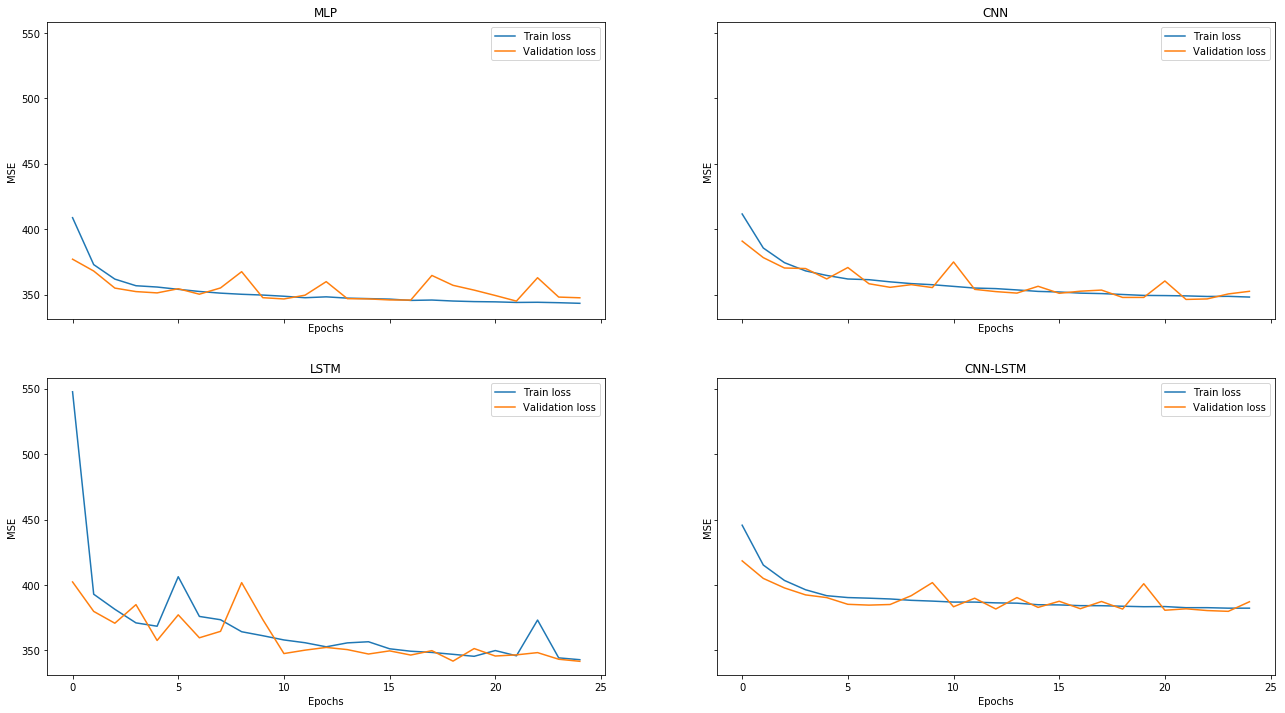

In [29]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

#### MLP on train and validation

In [30]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 18.554028044245367
Validation rmse: 18.644094004774253


#### CNN on train and validation

In [31]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 18.693781579342787
Validation rmse: 18.77620402583433


#### LSTM on train and validation

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

#### CNN-LSTM on train and validation

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

### Conclusion

Here you could see some approaches to a time series problem, how to develop and the differences between them, this is not meant to have a great performance, so if you want better results, you are more than welcomed to try a few different hyper-parameters, especially the window size and the networks topology, if you do, please let me know the results.

I hope you learned a few things here, leave a feedback and if you liked what you saw make sure to check the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/) that I used as source.